In [1]:
# import libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
# import pandas as pd
# import numpy as np
# import csv


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy import spatial
%matplotlib inline

## Start with dataset

In [2]:
# load dataset. Dataset from kaggle https://www.kaggle.com/gauravduttakiit/resume-dataset

df = pd.read_csv('UpdatedResumeDataSet.csv')

In [3]:
df

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
...,...,...
957,Testing,Computer Skills: â¢ Proficient in MS office (...
958,Testing,â Willingness to accept the challenges. â ...
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne..."
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...


In [4]:
df = df.drop_duplicates(ignore_index=True)
df

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
...,...,...
162,Testing,Computer Skills: â¢ Proficient in MS office (...
163,Testing,â Willingness to accept the challenges. â ...
164,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne..."
165,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...


In [5]:
df.head(11)

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
5,Data Science,"SKILLS C Basics, IOT, Python, MATLAB, Data Sci..."
6,Data Science,Skills â¢ Python â¢ Tableau â¢ Data Visuali...
7,Data Science,Education Details \r\n B.Tech Rayat and Bahr...
8,Data Science,Personal Skills â¢ Ability to quickly grasp t...
9,Data Science,Expertise â Data and Quantitative Analysis â...


In [6]:
df.tail()

,Category,Resume
162,Testing,Computer Skills: â¢ Proficient in MS office (...
163,Testing,â Willingness to accept the challenges. â ...
164,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne..."
165,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...
166,Testing,Skill Set OS Windows XP/7/8/8.1/10 Database MY...


In [7]:
df[df['Category']=='Data Science']

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
5,Data Science,"SKILLS C Basics, IOT, Python, MATLAB, Data Sci..."
6,Data Science,Skills â¢ Python â¢ Tableau â¢ Data Visuali...
7,Data Science,Education Details \r\n B.Tech Rayat and Bahr...
8,Data Science,Personal Skills â¢ Ability to quickly grasp t...
9,Data Science,Expertise â Data and Quantitative Analysis â...


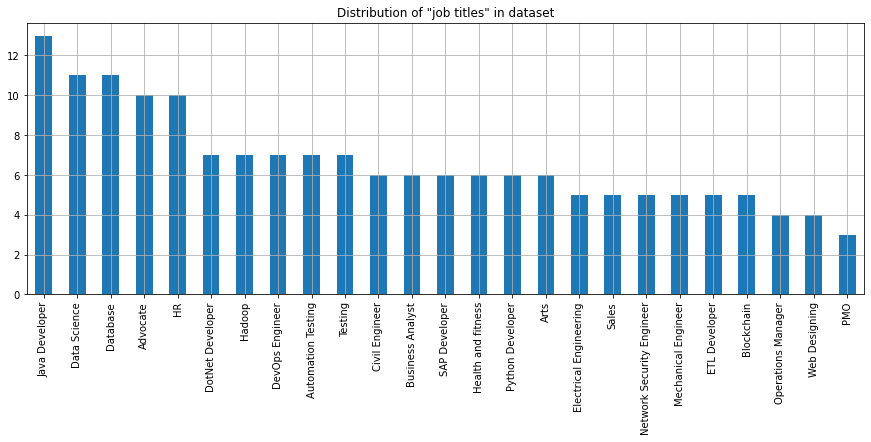

In [8]:
pd.value_counts(df['Category']).plot.bar(figsize=(15, 5))
plt.title('Distribution of "job titles" in dataset')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

Get resumes' lengths. Some of "categories" has too short resumes. This is not enough for good classification and feature extraction.

In [9]:
df['Resume_length'] = df['Resume'].str.len()

/Users/eugene404/Documents/GitHub/nlp/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


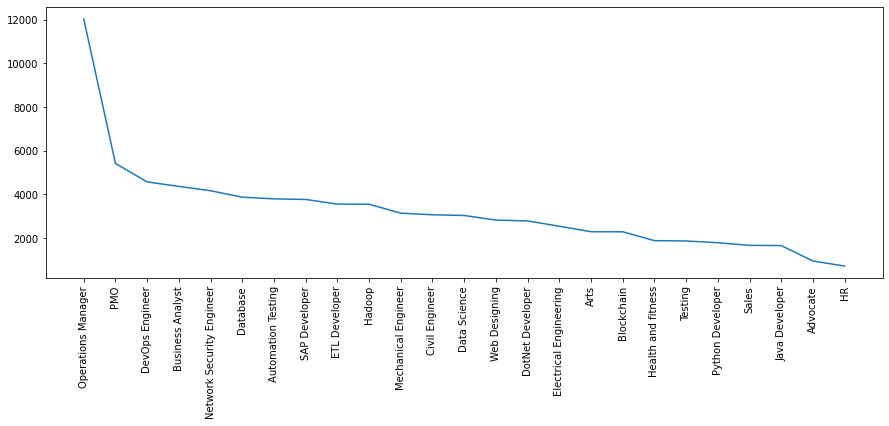

In [10]:
resume_length = df.groupby('Category').mean().sort_values(by='Resume_length', ascending=False)['Resume_length']
plt.figure(figsize=(15, 5))
plt.plot(resume_length)
plt.xticks(rotation=90)
plt.show()

For training the model with this data set will use more or less balanced categories, which are listed below.

In [11]:
columns_to_use = ['DevOps Engineer', 'Hadoop', 'Database', 'Data Science', 'Python Developer']
df_sliced = df[df['Category'].isin(columns_to_use)]
df_sliced = df_sliced.reset_index(drop=True)
df_sliced['Category'].unique()

array(['Data Science', 'Python Developer', 'DevOps Engineer', 'Database',
       'Hadoop'], dtype=object)

In [12]:
import re
import nltk
import string
from nltk.corpus import stopwords
en_stops = set(stopwords.words('english'))
for i in ['sir', 'sr']:
    en_stops.add(i)


# function for cleaning the data 
# get resume as input, delete html tags, https urls, etc and divide resume by sentences

# Return list of lists. Each list is generated sentence. These lists contains lowcase words (without stopwords)
def clean_text(raw_data):
    raw_data = raw_data.lower()
    clean_html = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext = re.sub(clean_html, '', raw_data)
    
    cleantext = re.sub('\r\n', '. ', cleantext)
    
    cleantext = re.sub(r'http\S+', '', cleantext)
    
    #remove any numeric characters
    cleantext = ''.join([word for word in cleantext if not word.isdigit()])  
    # remove RT and cc
    cleantext = re.sub('RT|cc', ' ', cleantext)
    # remove hashtags
    cleantext = re.sub('#\S+', '', cleantext)  
    # remove mentions
    cleantext = re.sub('@\S+', '  ', cleantext)  
    #replace consecutive non-ASCII characters with a space
    cleantext = re.sub(r'[^\x00-\x7f]',r' ', cleantext) 
    #extra whitespace removal
    cleantext = re.sub('\s+', ' ', cleantext)


#     cleantext = cleantext.replace('  ', '. ') 
    cleantext = cleantext.split('. ')

    cleantext = [i.strip() for i in cleantext if len(i)>1]    
    
    for i, sentns in enumerate(cleantext):
        tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
        words = tokenizer.tokenize(sentns)
        words = [w for w in words if w not in en_stops]
        cleantext[i] = words
        
    while True:
        clear = True
        index = []
        for i, sent in enumerate(cleantext):
            if len(sent) <= 2 and i != len(cleantext) - 1:
                clear = False
                cleantext[i+1] = cleantext[i] + cleantext[i+1]
                cleantext.pop(i)
            elif len(sent) <= 2 and i == len(cleantext) - 1:
                clear = False
                cleantext[i-1] = cleantext[i-1] + cleantext[i]
                cleantext.pop(i)
        if clear:
            break
    
    return cleantext

In [13]:
# example
# before cleaning
df_sliced.loc[3, 'Resume']

"Skills â\x80¢ R â\x80¢ Python â\x80¢ SAP HANA â\x80¢ Tableau â\x80¢ SAP HANA SQL â\x80¢ SAP HANA PAL â\x80¢ MS SQL â\x80¢ SAP Lumira â\x80¢ C# â\x80¢ Linear Programming â\x80¢ Data Modelling â\x80¢ Advance Analytics â\x80¢ SCM Analytics â\x80¢ Retail Analytics â\x80¢Social Media Analytics â\x80¢ NLP Education Details \r\nJanuary 2017 to January 2018 PGDM Business Analytics  Great Lakes Institute of Management & Illinois Institute of Technology\r\nJanuary 2013 Bachelor of Engineering Electronics and Communication Bengaluru, Karnataka New Horizon College of Engineering, Bangalore Visvesvaraya Technological University\r\nData Science Consultant \r\n\r\nConsultant - Deloitte USI\r\nSkill Details \r\nLINEAR PROGRAMMING- Exprience - 6 months\r\nRETAIL- Exprience - 6 months\r\nRETAIL MARKETING- Exprience - 6 months\r\nSCM- Exprience - 6 months\r\nSQL- Exprience - Less than 1 year months\r\nDeep Learning- Exprience - Less than 1 year months\r\nMachine learning- Exprience - Less than 1 year mo

In [14]:
# after cleaning
for i in clean_text(df_sliced.loc[3, 'Resume']):
    print(i)
    print()

['skills', 'r', 'python', 'sap', 'hana', 'tableau', 'sap', 'hana', 'sql', 'sap', 'hana', 'pal', 'ms', 'sql', 'sap', 'lumira', 'c', 'linear', 'programming', 'data', 'modelling', 'advance', 'analytics', 'scm', 'analytics', 'retail', 'analytics', 'social', 'media', 'analytics', 'nlp', 'education', 'details']

['january', 'january', 'pgdm', 'business', 'analytics', 'great', 'lakes', 'institute', 'management', 'illinois', 'institute', 'technology']

['january', 'bachelor', 'engineering', 'electronics', 'communication', 'bengaluru', 'karnataka', 'new', 'horizon', 'college', 'engineering', 'bangalore', 'visvesvaraya', 'technological', 'university']

['data', 'science', 'consultant']

['consultant', 'deloitte', 'usi']

['skill', 'details', 'linear', 'programming', 'exprience', 'months']

['retail', 'exprience', 'months']

['retail', 'marketing', 'exprience', 'months']

['scm', 'exprience', 'months']

['sql', 'exprience', 'less', 'year', 'months']

['deep', 'learning', 'exprience', 'less', 'yea

In [15]:
# apply this funciton to resumes in DataFrame
df_sliced['Resume'] = df_sliced['Resume'].apply(clean_text)

In [16]:
df_sliced.head()

,Category,Resume,Resume_length
0,Data Science,"[[skills, programming, languages, python, pand...",4786
1,Data Science,"[[education, details, may, may, b, e, uit, rgp...",1267
2,Data Science,"[[areas, interest, deep, learning, control, sy...",1871
3,Data Science,"[[skills, r, python, sap, hana, tableau, sap, ...",6995
4,Data Science,"[[education, details, mca, ymcaust, faridabad,...",452


## Embedings

In [42]:
from collections import Counter

# create vocabulary
vocabulary = []
for resume in df_sliced['Resume']:
    for sentence in resume:
        for w in sentence:
            vocabulary.append(w)
            
# use only 500 most common words (hyperparameter)
vocabulary, counts = zip(*Counter(vocabulary).most_common(200))

In [43]:
len(vocabulary)

200

In [44]:
corpus = [] # list of all sentences
for resume in df_sliced['Resume']:
    for sentence in resume:
        corpus.append(sentence)

In [45]:
# use "unk" as unknown words for non-vocabulary words
corpus = [[w if w in vocabulary else 'unk' for w in sentence] for sentence in corpus]
vocabulary += ('unk',) # Add "unk" to vocabulary
counts += (sum([w == 'unk' for s in corpus for w in s]),) # Add count for "unk"

In [46]:
VOCABULARY_SIZE = len(vocabulary)
EMBEDDING_DIM = 64 # (hyperparameter)

In [47]:
VOCABULARY_SIZE

201

In [57]:
# Dictionaries for converting words to index, index to words and index to frequency of this word
word_to_ind = {w: vocabulary.index(w) for w in vocabulary}

ind_to_word = {i: vocabulary[i] for i in range(len(vocabulary))}

ind_to_freq = {i: counts[i] for i in range(len(vocabulary))}

In [58]:
word_to_ind['learning'], ind_to_freq[word_to_ind['learning']]

(17, 64)

In [59]:
word_to_ind['project'], ind_to_freq[word_to_ind['project']]

(7, 132)

In [60]:
def get_window(sentence, window_size):
    pairs = []

    """
    Iterate over all the sentences
    Take all the words from [i - window_size) to (i + window_size] and save them to pairs
    
    Parameters
    ----------
    sentence: list
        List of sentences. Sentence is a list of words (str)
    window_size: int
        Positive scalar
        
    Returns
    -------
    pairs: list
        A list of tuple (word index, word index from its context)
    """

    pairs = []
    for ind_w in range(len(sentence)):
        window_ind = [i for i in range(ind_w - window_size, ind_w + window_size + 1) 
                      if i != ind_w and i >= 0 and i <= len(sentence)-1]
        for win_ind_i in window_ind:
            pairs.append((word_to_ind[sentence[ind_w]], word_to_ind[sentence[win_ind_i]]))

    return pairs

In [61]:
data = []
for x in corpus:
    data += get_window(x, window_size=3)
data = np.array(data)

print('First 5 pairs:', data[:5].tolist())
print('First 5 pairs words:', [[ind_to_word[index] for index in window] for window in data[:5].tolist()])
print('Total number of pairs:', data.shape[0])

First 5 pairs: [[44, 122], [44, 189], [44, 9], [122, 44], [122, 189]]
First 5 pairs words: [['skills', 'programming'], ['skills', 'languages'], ['skills', 'python'], ['programming', 'skills'], ['programming', 'languages']]
Total number of pairs: 66444


We calculate a weighting score to counter the imbalance between the rare and frequent words. Rare words will be sampled more frequently. https://arxiv.org/pdf/1310.4546.pdf

In [62]:
probabilities = [1 - np.sqrt(1e-3 / ind_to_freq[x]) for x in data[:,0]]
probabilities /= np.sum(probabilities)

### Skip-gram embedding

Predicts thesurrounding context from the current word

In [63]:
class Embedding():
    """
    Word embedding model.

    Parameters
    ----------
    N: int
        Number of unique words in the vocabulary
    D: int
        Dimension of the word vector embedding
    """
    def __init__(self, N, D):
        self.N = N
        self.D = D

        self.ctx = None # Used to store values for backpropagation

        self.U = None
        self.V = None
        self.reset_parameters()

    def reset_parameters(self):
        """
        init weight matrices U and V, dimension (D, N) and (N, D) respectively
        """
        self.ctx = None
        self.U = np.random.normal(0, np.sqrt(6. / (self.D + self.N)), (self.D, self.N))
        self.V = np.random.normal(0, np.sqrt(6. / (self.D + self.N)), (self.N, self.D))

    def one_hot(self, x):
        """
        Given a vector returns a matrix with rows corresponding to one-hot encoding.
        
        Parameters
        ----------
        x: array
            M-dimensional vector containing integers from [0, N]
        
        Returns
        -------
        one_hot: array
            (N, M) matrix, each column is N-dimensional one-hot encoding of elements from x 
        """

        one_hot = np.zeros((self.N, x.shape[0]))
        for i, x_i in enumerate(x):
            one_hot[x_i, i] = 1

        assert one_hot.shape == (self.N, x.shape[0]), 'Incorrect one-hot embedding shape'
        return one_hot

    def softmax(self, x, axis):
        """
        Parameters
        ----------
        x: array
            A non-empty matrix of any dimension
        axis: int
            Dimension on which softmax is performed
            
        Returns
        -------
        y: array
            Matrix of same dimension as x with softmax applied to 'axis' dimension
        """
        
        # numerically stable version of softmax
        
        # if axis==0 we apply by rows, if axis==1 we apply by columns
        y = np.zeros(x.shape)
        if axis==0:
            for i in range(x.shape[0]):
                x_i = np.array(x[i])
                x_i = x_i - np.max(x_i)
                y[i] = np.exp(x_i) / np.sum(np.exp(x_i))
                
        elif axis==1:
            for j in range(x.shape[1]):
                x_j = np.array(x[:, j])
                x_j = x_j - np.max(x_j)
                y[:, j] = np.exp(x_j) / np.sum(np.exp(x_j))
                
        
        assert x.shape == y.shape, 'Output should have the same shape is input'
        return y

    def loss(self, y, prob):
        """
        Parameters
        ----------
        y: array
            (N, M) matrix of M samples where columns are one-hot vectors for true values
        prob: array
            (N, M) column of M samples where columns are probability vectors after softmax

        Returns
        -------
        loss: int
            Cross-entropy loss
        """

        prob = np.clip(prob, 1e-8, None)
        
        loss = -1 / y.shape[1] * (y*np.log(prob)).sum()
        
        assert isinstance(loss, float), 'Loss must be a scalar'
        return loss

    def forward(self, x, y):
        """        
        Parameters
        ----------
        x: array
            M-dimensional vector containing integers from [0, N]
        y: array
            Output words, same dimension and type as 'x'
        learning_rate: float
            A positive scalar determining the update rate
            
        Returns
        -------
        loss: float
        d_U: array
        d_V: array
        """
        
        # Input transformation

        x = self.one_hot(x)
        y = self.one_hot(y)
        
        # Forward propagation

        embedding = self.U[:, np.argmax(x, axis=0)]
        logits = np.dot(self.V, embedding)
        prob = self.softmax(logits, axis=1)

        assert embedding.shape == (self.D, x.shape[1])
        assert logits.shape == (self.N, x.shape[1])
        assert prob.shape == (self.N, x.shape[1])
        
        # Save values for backpropagation
        self.ctx = (embedding, logits, prob, x, y)
        
        # Loss calculation
        loss = self.loss(y, prob)
        
        return loss
        
    def backward(self):
        """
        Returns gradient of U and V.
        
        Returns
        -------
        d_V: array
        d_U: array
        """

        embedding, logits, prob, x, y = self.ctx

        d_V = np.dot((prob - y), embedding.T)
        d_U = np.dot(np.dot((prob - y).T, self.V).T, x.T)

        assert d_V.shape == (self.N, self.D)
        assert d_U.shape == (self.D, self.N)

        return { 'V': d_V, 'U': d_U }

In [64]:
class Optimizer:
    """
    Stochastic gradient descent with momentum optimizer.

    Parameters
    ----------
    model: object
    learning_rate: float
    momentum: float (optional)(default: 0)
    """
    def __init__(self, model, learning_rate, momentum=0):
        self.model = model
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        self.previous = None # Previous gradients
    
    def _init_previous(self, grad):
        # Initialize previous gradients to zero
        self.previous = { k: np.zeros_like(v) for k,v in grad.items() }
    
    def step(self, grad):
        if self.previous is None:
            self._init_previous(grad)
            
        for name, dw in grad.items():
            dw_prev = self.previous[name]
            w = getattr(self.model, name)

#             Given weight w, previous gradients dw_prev and current 
#             gradients dw, performs an update of weight w.

            dw_new = self.momentum * dw_prev + self.learning_rate * dw
            w_new = w - dw_new

            self.previous[name] = dw_new
            setattr(self.model, name, w_new)

In [65]:
def get_loss(model, old, variable, epsilon, x, y, i, j):
    np.random.seed(123)
    model.reset_parameters() # reset weights
    
    delta = np.zeros_like(old)
    delta[i, j] = epsilon
    
    setattr(model, variable, old + delta) # change one weight by a small amount
    loss = model.forward(x, y)

    return loss

In [66]:
rng = np.random.default_rng(123)
def get_batch(data, size, prob):
    x = rng.choice(data, size, p=prob)
    return x[:,0], x[:,1]

In [67]:
VOCABULARY_SIZE

201

### training embeddings

In [68]:
model = Embedding(N=VOCABULARY_SIZE, D=EMBEDDING_DIM)
optim = Optimizer(model, learning_rate=1e-3, momentum=0.5)

losses = []

MAX_ITERATIONS = 30000
PRINT_EVERY = 1000
BATCH_SIZE = 1000

for i in range(MAX_ITERATIONS):
    x, y = get_batch(data, BATCH_SIZE, probabilities)
    
    loss = model.forward(x, y)
    grad = model.backward()
    optim.step(grad)
    
    assert not np.isnan(loss)
    
    losses.append(loss)

    if (i + 1) % PRINT_EVERY == 0:
        print(f'Iteration: {i + 1}, Avg. training loss: {np.mean(losses[-PRINT_EVERY:]):.4f}')

Iteration: 1000, Avg. training loss: 3.0553
Iteration: 2000, Avg. training loss: 2.8278
Iteration: 3000, Avg. training loss: 2.7614
Iteration: 4000, Avg. training loss: 2.7309
Iteration: 5000, Avg. training loss: 2.7122
Iteration: 6000, Avg. training loss: 2.6956
Iteration: 7000, Avg. training loss: 2.6799
Iteration: 8000, Avg. training loss: 2.6685
Iteration: 9000, Avg. training loss: 2.6628
Iteration: 10000, Avg. training loss: 2.6594
Iteration: 11000, Avg. training loss: 2.6512
Iteration: 12000, Avg. training loss: 2.6474
Iteration: 13000, Avg. training loss: 2.6413
Iteration: 14000, Avg. training loss: 2.6375
Iteration: 15000, Avg. training loss: 2.6397
Iteration: 16000, Avg. training loss: 2.6311
Iteration: 17000, Avg. training loss: 2.6271
Iteration: 18000, Avg. training loss: 2.6346
Iteration: 19000, Avg. training loss: 2.6341
Iteration: 20000, Avg. training loss: 2.6271
Iteration: 21000, Avg. training loss: 2.6279
Iteration: 22000, Avg. training loss: 2.6272
Iteration: 23000, A

In [69]:
emb_matrix = model.U.T
# emb_matrix = np.load('emb_matrix.npy')

In [109]:
np.save('emb_matrix', emb_matrix)

## Example

Use triples of words from vocabulary. Try to find more reliable surrounding word.

In [70]:
triplets = [['machine', 'learning', 'learning'], ['machine', 'learning', 'python'],
           ['deep', 'learning', 'javascript'],]

for triplet in triplets:
    a, b, d = triplet

    """
    Returns
    
    Example: Paris (a) is to France (b) as _____ (c) is to Germany (d)
    
    -------
    result: array
        The embedding vector for word (c): w_a - w_b + w_d
    """

    w_a, w_b, w_d = emb_matrix[word_to_ind[a]], emb_matrix[word_to_ind[b]], emb_matrix[word_to_ind[d]]
    result = w_a - w_b + w_d

    distances = [spatial.distance.cosine(x, result) for x in emb_matrix]
    candidates = [ind_to_word[i] for i in np.argsort(distances)]
    candidates = [x for x in candidates if x not in [a, b, d]][:5]

    print(f'`{a}` is to `{b}` as [{", ".join(candidates)}] is to `{d}`')

`machine` is to `learning` as [deep, algorithms, microsoft, science, operating] is to `learning`
`machine` is to `learning` as [css, java, core, sqoop, web] is to `python`
`deep` is to `learning` as [training, year, css, linux, sql] is to `javascript`


# To be continued ... 
not finished yet

In [71]:
from torch.utils.data import Dataset
from sklearn import preprocessing


class ResumeDataset(Dataset):
    def __init__(self, df, embedding_matrix, word_to_ind_f, vocabulary, unk_word='unk'):
        self.df = df.copy()

        # list of Tensors with different lengths; 
        # list of sentences; 
        
        # sentence is list of words; 
        # word is vector (embedded)
        
        self.df['Resume'] = self.df['Resume'].apply(lambda resume: [sentence for sentence in resume if sentence])
        self.df['Resume'] = self.df['Resume'].apply(lambda resume: 
                                                    [torch.Tensor([embedding_matrix[word_to_ind_f[a]] 
                                                                   if a in vocabulary 
                                                                   else embedding_matrix[word_to_ind_f[unk_word]]
                                                                   for a in sentence]) 
                                                     for sentence in resume])
                                                

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """
        return:
            resume - 
            label - is int number
        """
        row = self.df.loc[idx, ['Resume', 'Category_label']]
        
        length = [int(sentence.shape[0]) for sentence in row['Resume']]
        # padding with 0 to same sizes
        resume = torch.nn.utils.rnn.pad_sequence(row['Resume'], batch_first=True)

        
        return resume, length, int(row['Category_label'])

<b>encode category label

In [72]:
# Label encoding for category
le = preprocessing.LabelEncoder()
le.fit(df_sliced['Category'].values)
print(le.classes_)
df_sliced['Category_label'] = df_sliced['Category'].apply(lambda x: le.transform([x])[0])
df_sliced

['Data Science' 'Database' 'DevOps Engineer' 'Hadoop' 'Python Developer']


,Category,Resume,Resume_length,Category_label
0,Data Science,"[[skills, programming, languages, python, pand...",4786,0
1,Data Science,"[[education, details, may, may, b, e, uit, rgp...",1267,0
2,Data Science,"[[areas, interest, deep, learning, control, sy...",1871,0
3,Data Science,"[[skills, r, python, sap, hana, tableau, sap, ...",6995,0
4,Data Science,"[[education, details, mca, ymcaust, faridabad,...",452,0
5,Data Science,"[[skills, c, basics, iot, python, matlab, data...",708,0
6,Data Science,"[[skills, python, tableau, data, visualization...",1700,0
7,Data Science,"[[education, details, b, tech, rayat, bahra, i...",8192,0
8,Data Science,"[[personal, skills, ability, quickly, grasp, t...",1778,0
9,Data Science,"[[expertise, data, quantitative, analysis, dec...",4381,0


<hr>

- <b>Create train and test df for training model for all classes at once</b>
- <b>Create dict_train_test_df for training models for each class separately</b>

In [73]:
# train test split
train_split = 1-0.15
# dict_train_test_df = {}

train_df = []
test_df = []
for category in df_sliced['Category'].unique():
    category_df = df_sliced[df_sliced['Category']==category]
    
    train_category_df = category_df[:int(len(category_df)*train_split)]
    test_category_df = category_df[int(len(category_df)*train_split):]
    
    train_df.append(train_category_df)
    test_df.append(test_category_df)
    
#     dict_train_test_df[f'{category}_train'] = train_category_df
#     dict_train_test_df[f'{category}_test'] = test_category_df
    
train_df = pd.concat(train_df, ignore_index=True)
test_df = pd.concat(test_df, ignore_index=True)

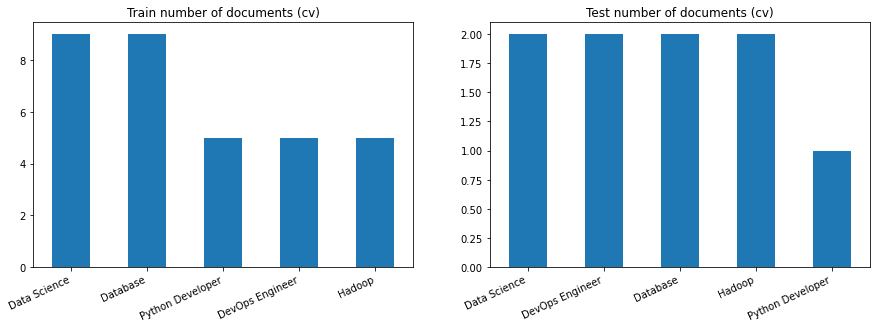

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.autofmt_xdate(rotation=25)

pd.value_counts(train_df['Category']).plot.bar(ax=ax[0], rot=25)
ax[0].set_title('Train number of documents (cv)')


pd.value_counts(test_df['Category']).plot.bar(ax=ax[1], rot=25)
ax[1].set_title('Test number of documents (cv)')
plt.show()

In [75]:
# dict_train_test_df.keys()

In [76]:
train_all_dataset = ResumeDataset(train_df, emb_matrix, word_to_ind, vocabulary)
test_all_dataset = ResumeDataset(test_df, emb_matrix, word_to_ind, vocabulary)

In [80]:
resume, length, label = train_all_dataset[2]
row = train_df.iloc[2, :]
print('resume len (number of sentences): ResumeDataset =', len(resume), ', train_df =', len(row['Resume']))
print('resume label : ResumeDataset =', label, ', train_df =', row['Category_label'])
print('ResumeDataset resume shape', resume.shape)  
length

resume len (number of sentences): ResumeDataset = 17 , train_df = 17
resume label : ResumeDataset = 0 , train_df = 0
ResumeDataset resume shape torch.Size([17, 50, 64])


[24, 50, 3, 6, 3, 5, 4, 6, 8, 5, 6, 5, 5, 5, 6, 6, 43]

In [81]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_all_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_all_dataset, batch_size=1, shuffle=True)

In [82]:
train_features, train_lengths, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels}")
print(f"Lengths batch shape: {[int(i[0]) for i in train_lengths]}")

Feature batch shape: torch.Size([1, 43, 40, 64])
Labels batch shape: tensor([1])
Lengths batch shape: [40, 6, 3, 4, 3, 7, 5, 3, 6, 5, 6, 5, 6, 4, 6, 8, 6, 5, 15, 11, 5, 9, 18, 13, 9, 9, 10, 6, 11, 9, 5, 9, 8, 7, 4, 7, 8, 8, 8, 6, 10, 12, 27]


<hr>

<i> plot dict_train_test_df

In [83]:
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
# fig.autofmt_xdate(rotation=25)

# ax[0].bar([i for i in dict_train_test_df.keys() if 'train' in i], 
#         [len(dict_train_test_df[key]) for key in dict_train_test_df.keys() if 'train' in key])
# ax[0].set_title('Train number of documents (cv)')


# ax[1].bar([i for i in dict_train_test_df.keys() if 'test' in i], 
#         [len(dict_train_test_df[key]) for key in dict_train_test_df.keys() if 'test' in key])
# ax[1].set_title('Test number of documents (cv)')
# plt.show()

<hr>

<b>For each category we create df with Category_label=1 for same category and Category_label=0 for others</b>

<b>For each category we add Category_label=0 from all others categories equally</b>

In [84]:
# category_count = len(df_sliced['Category'].unique())
# for category in df_sliced['Category'].unique():
#     # train
#     df_choosed = dict_train_test_df[f'{category}_train'].copy()
#     df_choosed['Category_label'] = 1
    
#     piece = len(df_choosed) // (category_count-1)
    
#     for add_train_category in [i for i in dict_train_test_df.keys() if 'train' in i and f'{category}_train' != i]:
#         iloc = np.random.choice(len(dict_train_test_df[add_train_category]), piece, replace=False)
#         add_train_df = dict_train_test_df[add_train_category].iloc[iloc, :].copy()
#         add_train_df['Category_label'] = 0
#         df_choosed = pd.concat([df_choosed, add_train_df], ignore_index=True)
        
#     dict_train_test_df[f'{category}_train'] = df_choosed
    
#     # test
#     df_choosed = dict_train_test_df[f'{category}_test'].copy()
#     df_choosed['Category_label'] = 1
    
#     piece = len(df_choosed) // (category_count-1)
    
#     for add_test_category in [i for i in dict_train_test_df.keys() if 'test' in i and f'{category}_test' != i]:
#         iloc = np.random.choice(len(dict_train_test_df[add_test_category]), piece, replace=False)
#         add_train_df = dict_train_test_df[add_test_category].iloc[iloc, :].copy()
#         add_train_df['Category_label'] = 0
#         df_choosed = pd.concat([df_choosed, add_train_df], ignore_index=True)
        
#     dict_train_test_df[f'{category}_test'] = df_choosed

<br>
<i>plot df</i>
<br>

In [85]:
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
# fig.autofmt_xdate(rotation=25)

# labels = [i for i in dict_train_test_df.keys() if 'train' in i]
# x = np.arange(len(labels))  # the label locations
# width = 0.35  # the width of the bars

# rects1 = ax[0].bar(x - width/2, 
#                   [sum(dict_train_test_df[key]['Category_label'] == 1) for key in dict_train_test_df.keys() 
#                    if 'train' in key], width,
#                    label='Category label == 1')
# rects2 = ax[0].bar(x + width/2, 
#                   [sum(dict_train_test_df[key]['Category_label'] == 0) for key in dict_train_test_df.keys() 
#                    if 'train' in key], width,
#                    label='Category label == 0')
# ax[0].set_title('Train number of documents (cv)')

# ax[0].set_ylabel('number')
# ax[0].set_xticks(x)
# ax[0].set_xticklabels(labels)
# ax[0].legend()

# ax[0].bar_label(rects1, padding=3)
# ax[0].bar_label(rects2, padding=3)

# labels = [i for i in dict_train_test_df.keys() if 'test' in i]
# x = np.arange(len(labels))  # the label locations
# width = 0.35  # the width of the bars

# rects1 = ax[1].bar(x - width/2, 
#                   [sum(dict_train_test_df[key]['Category_label'] == 1) for key in dict_train_test_df.keys() 
#                    if 'test' in key], width,
#                    label='Category label == 1')
# rects2 = ax[1].bar(x + width/2, 
#                   [sum(dict_train_test_df[key]['Category_label'] == 0) for key in dict_train_test_df.keys() 
#                    if 'test' in key], width,
#                    label='Category label == 0')
# ax[1].set_title('Test number of documents (cv)')

# ax[1].set_ylabel('number')
# ax[1].set_xticks(x)
# ax[1].set_xticklabels(labels)
# ax[1].legend()

# ax[1].bar_label(rects1, padding=3)
# ax[1].bar_label(rects2, padding=3)


# fig.tight_layout()

# plt.show()

In [86]:
# datasets = {}
# for category in df_sliced['Category'].unique():
#         datasets[category] = [ResumeDataset(dict_train_test_df[f'{category}_train'], 
#                                             emb_matrix, word_to_ind, vocabulary),
#                               ResumeDataset(dict_train_test_df[f'{category}_test'], 
#                                             emb_matrix, word_to_ind, vocabulary)]

In [87]:

class WordAttention(nn.Module):
    def __init__(self, embed_size, hidden_size=50):
        """

        :param embed_size: embedding size
        :param hidden_size: size of hidden layers
        """
        super(WordAttention, self).__init__()

        self.attn_word = nn.Linear(2 * hidden_size, 2 * hidden_size)
        self.context_word = nn.Linear(2 * hidden_size, 1, bias=False)

        self.gru_word = nn.GRU(embed_size, hidden_size, bidirectional=True, batch_first=True)

    def forward(self, data, lengths, hidden_state):
        """

        :param data: list of np.arrays or torch.Tensors
        :param hidden_state: of gru_word
        :return:
        """

        batch_data = torch.nn.utils.rnn.pack_padded_sequence(data, batch_first=True,
                                                             lengths=lengths)

        f_output, h_output = self.gru_word(batch_data, hidden_state)  # feature output and hidden state output

        f_output_unpacked, _ = torch.nn.utils.rnn.pad_packed_sequence(f_output, batch_first=True)

        u = torch.tanh_(self.attn_word(f_output_unpacked))
        a = F.softmax(self.context_word(u), dim=1)

        output = (a * f_output_unpacked).sum(1)

        return output, h_output


class SentenceAttention(nn.Module):
    def __init__(self, sent_hidden_size=50, word_hidden_size=50, num_classes=14):
        super(SentenceAttention, self).__init__()

        self.attn_sentence = nn.Linear(2 * sent_hidden_size, 2 * sent_hidden_size)
        self.context_sentence = nn.Linear(2 * sent_hidden_size, 1, bias=False)

        self.gru_sentence = nn.GRU(2 * word_hidden_size, sent_hidden_size, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(2 * sent_hidden_size, num_classes)

    def forward(self, batch_data, hidden_state):
        f_output, h_output = self.gru_sentence(batch_data, hidden_state)  # feature output and hidden state output

        u = torch.tanh_(self.attn_sentence(f_output))
        a = F.softmax(self.context_sentence(u), dim=1)

        output = (a * f_output).sum(1)
        output = self.fc(output)

        return output, h_output


class HAN(nn.Module):
    def __init__(self, word_embed_size, word_hidden_size, sent_hidden_size, batch_size, num_classes):

        super(HAN, self).__init__()
        self.batch_size = batch_size
        self.word_hidden_size = word_hidden_size
        self.sent_hidden_size = sent_hidden_size
        self.word_att_net = WordAttention(word_embed_size, word_hidden_size)
        self.sent_att_net = SentenceAttention(sent_hidden_size, word_hidden_size, num_classes)
        self._init_hidden_state()

    def _init_hidden_state(self):

        self.word_hidden_state = torch.zeros(2, self.batch_size, self.word_hidden_size)
        self.sent_hidden_state = torch.zeros(2, self.batch_size, self.sent_hidden_size)

    def forward(self, input_data, lengths_of_data):
        """
        input_data: [1, num_sentences, num_words, emb_word_size]
        lengths_of_data: list of lengths foe each sentence (without padding)
        """

        output_list = []
        
        for i in range(input_data.shape[1]):  
            output, self.word_hidden_state = self.word_att_net(input_data[:, i], 
                                                               [lengths_of_data[i]], 
                                                               self.word_hidden_state)
            output_list.append(output)
            
        output = torch.cat(output_list, 0).unsqueeze(0)
        output, self.sent_hidden_state = self.sent_att_net(output, self.sent_hidden_state)

        return output


In [88]:
train_features, train_lengths, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels}")
print(f"Lengths batch shape: {[int(i[0]) for i in train_lengths]}")

model = HAN(EMBEDDING_DIM, word_hidden_size=50, sent_hidden_size=50, 
            batch_size=1, num_classes=len(df_sliced['Category'].unique()))

Feature batch shape: torch.Size([1, 17, 50, 64])
Labels batch shape: tensor([0])
Lengths batch shape: [24, 50, 3, 6, 3, 5, 4, 6, 8, 5, 6, 5, 5, 5, 6, 6, 43]


In [89]:
model(train_features, [int(i[0]) for i in train_lengths])

tensor([[ 0.1536, -0.0865,  0.0070, -0.0724, -0.0316]],
       grad_fn=<AddmmBackward>)

In [90]:
from sklearn import metrics

def get_evaluation(y_true, y_prob, list_metrics):
    y_pred = np.argmax(y_prob, -1)
    output = {}
    if 'accuracy' in list_metrics:
        output['accuracy'] = metrics.accuracy_score(y_true, y_pred)
    if 'loss' in list_metrics:
        try:
            output['loss'] = metrics.log_loss(y_true, y_prob)
        except ValueError:
            output['loss'] = -1
    if 'confusion_matrix' in list_metrics:
        output['confusion_matrix'] = str(metrics.confusion_matrix(y_true, y_pred))
    return output

In [91]:
train_dataloader = DataLoader(train_all_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_all_dataset, batch_size=1, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 0.01, momentum=0.9)

best_loss = 1e5
best_epoch = 0
num_epoches = 15
test_interval = 1

for epoch in range(num_epoches):
    acc_temp = 0
    loss_temp = 0
    for feature, lengths, label in train_dataloader:

        optimizer.zero_grad()
        model._init_hidden_state()
        
        predictions = model(feature, [int(i[0]) for i in lengths])
        
        loss = criterion(predictions, label)
        loss.backward()
        optimizer.step()
        
        training_metrics = get_evaluation(label.cpu().numpy(), predictions.cpu().detach().numpy(), list_metrics=["accuracy"])
        acc_temp += training_metrics["accuracy"]
        loss_temp += loss
        
    acc_temp = acc_temp/len(train_dataloader)
    loss_temp = loss_temp/len(train_dataloader)
    
    print("(Train) Epoch: {}/{} Loss: {}, Accuracy: {}".format(
        epoch + 1,
        num_epoches,
        loss_temp, acc_temp))
        
    if epoch % test_interval == 0:
        model.eval()
        loss_ls = []
        te_label_ls = []
        te_pred_ls = []
        for te_feature, te_length, te_label in test_dataloader:
            with torch.no_grad():
                model._init_hidden_state()
                te_predictions = model(te_feature, [int(i[0]) for i in te_length])
                
            te_loss = criterion(te_predictions, te_label)
            loss_ls.append(te_loss)
            te_label_ls.extend(te_label.clone().cpu())
            te_pred_ls.append(te_predictions.clone().cpu())
            
        te_loss = sum(loss_ls) / len(loss_ls)
        te_pred = torch.cat(te_pred_ls, 0)
        te_label = np.array(te_label_ls)
        test_metrics = get_evaluation(te_label, te_pred.numpy(), list_metrics=["accuracy", "confusion_matrix"])

        print("(Test)  Epoch: {}/{}, Loss: {}, Accuracy: {}".format(
            epoch + 1,
            num_epoches,
            te_loss, test_metrics["accuracy"]))
#         print(test_metrics["confusion_matrix"])
        
#         if te_loss + opt.es_min_delta < best_loss:
#             best_loss = te_loss
#             best_epoch = epoch
#             torch.save(model, opt.saved_path + os.sep + "whole_model_han")

#         # Early stopping
#         if epoch - best_epoch > opt.es_patience > 0:
#             print("Stop training at epoch {}. The lowest loss achieved is {}".format(epoch, te_loss))
#             break


(Train) Epoch: 1/15 Loss: 1.6558308601379395, Accuracy: 0.24242424242424243
(Test)  Epoch: 1/15, Loss: 1.554436445236206, Accuracy: 0.2222222222222222
(Train) Epoch: 2/15 Loss: 1.500501275062561, Accuracy: 0.36363636363636365
(Test)  Epoch: 2/15, Loss: 1.4903548955917358, Accuracy: 0.3333333333333333
(Train) Epoch: 3/15 Loss: 1.3871759176254272, Accuracy: 0.45454545454545453
(Test)  Epoch: 3/15, Loss: 1.4289422035217285, Accuracy: 0.2222222222222222
(Train) Epoch: 4/15 Loss: 1.3280869722366333, Accuracy: 0.45454545454545453
(Test)  Epoch: 4/15, Loss: 1.212172031402588, Accuracy: 0.4444444444444444
(Train) Epoch: 5/15 Loss: 1.0606553554534912, Accuracy: 0.6060606060606061
(Test)  Epoch: 5/15, Loss: 1.2738873958587646, Accuracy: 0.5555555555555556
(Train) Epoch: 6/15 Loss: 1.0736624002456665, Accuracy: 0.6363636363636364
(Test)  Epoch: 6/15, Loss: 1.4833537340164185, Accuracy: 0.2222222222222222
(Train) Epoch: 7/15 Loss: 0.9498186707496643, Accuracy: 0.5757575757575758
(Test)  Epoch: 7/1

In [92]:
for te_feature, te_length, te_label in test_dataloader:
    with torch.no_grad():
        model._init_hidden_state()
        print(te_label[0], 'label')
        te_predictions = model(te_feature, [int(i[0]) for i in te_length])
        print(te_predictions[0], 'prediction')
            

tensor(4) label
tensor([ 1.2580, -3.8307,  0.3406, -1.6820,  3.7901]) prediction
tensor(2) label
tensor([ 0.5189, -2.3453,  3.0454, -2.7186,  1.5117]) prediction
tensor(1) label
tensor([-4.8070,  7.9495,  1.9609, -0.4428, -3.7202]) prediction
tensor(0) label
tensor([ 4.6169, -4.4972, -0.6783,  1.7756, -1.5677]) prediction
tensor(2) label
tensor([-0.6099, -0.7004,  3.6344, -4.1683,  1.9201]) prediction
tensor(1) label
tensor([ 0.3027,  1.2677,  1.0078, -1.0299, -1.4513]) prediction
tensor(0) label
tensor([ 5.9442, -5.7668, -0.5208, -1.7762,  1.3900]) prediction
tensor(3) label
tensor([ 2.2341, -2.7512, -0.6835,  5.6628, -4.1447]) prediction
tensor(3) label
tensor([ 2.3627, -3.5390, -0.7781,  5.0564, -2.8554]) prediction


In [90]:
# for i in range(0, 100, 10):
#     resume, length, label = train_all_dataset[i]
#     print('Resume label ', label)
#     print('Predict', model(resume.unsqueeze(0), length))

In [105]:
import matplotlib
from IPython.display import display, HTML

def sentence_color(sentence, attention, sentence_attention_value):

    def colorize(words, color_array):
        # words is a list of words
        # color_array is an array of numbers between 0 and 1 of length equal to words
        cmap = matplotlib.cm.get_cmap('binary')
        template = '<span class="barcode"; style="color: black; border-style: solid; border-color: {}">{}</span>'
        colored_string = ''
        for i, (word, color) in enumerate(zip(words, color_array)):
            color = matplotlib.colors.rgb2hex(cmap(color)[:3])
            colored_string += template.format(color, '&nbsp' + word + '&nbsp')
            if i%10 == 0 and i!=0:
                colored_string += '<br>'
        return colored_string

    s = colorize(sentence, attention)
    s = f'<span class="barcode"; style="color: black;"> <b>Sent. attention value is {sentence_attention_value}</b></span><br>' + s

    # to display in ipython notebook
    return s


In [106]:
len(train_all_dataset)

33

In [120]:
def attention_print(model, encoded_resume, length, resume):
    
    def model_word_forward(batch_data, lengths_word, hidden_state):
        batch_data = torch.nn.utils.rnn.pack_padded_sequence(batch_data, batch_first=True,
                                                             lengths=lengths_word)

        f_output, h_output = model.word_att_net.gru_word(batch_data, hidden_state)  # feature output and hidden state output
        f_output_unpacked, _ = torch.nn.utils.rnn.pad_packed_sequence(f_output, batch_first=True)

        u = torch.tanh_(model.word_att_net.attn_word(f_output_unpacked))
        a = F.softmax(model.word_att_net.context_word(u), dim=1)

        output = (a * f_output_unpacked).sum(1)

        return output, h_output, a
    
    def model_sent_forward(batch_data, hidden_state):
        f_output, h_output = model.sent_att_net.gru_sentence(batch_data, hidden_state)  # feature output and hidden state output

        u = torch.tanh_(model.sent_att_net.attn_sentence(f_output))
        a = F.softmax(model.sent_att_net.context_sentence(u), dim=1)

        output = (a * f_output).sum(1)
        output = model.sent_att_net.fc(output)

        return output, h_output, a

    output_list = []
    word_att_list = []

    for i in range(encoded_resume.shape[1]):  
        output, model.word_hidden_state, word_att = model_word_forward(encoded_resume[:, i], 
                                                           [length[i]], 
                                                           model.word_hidden_state)
        output_list.append(output)
        word_att_list.append(word_att)

    output = torch.cat(output_list, 0).unsqueeze(0)
    output, model.sent_hidden_state, sent_att = model_sent_forward(output, model.sent_hidden_state)
    
    sent_att = sent_att.flatten().tolist()
    
    assert len(sent_att) == len(resume)
    assert len(word_att_list) == len(resume)
    
    display_str = ''
    sorted_indexes = np.argsort(sent_att)
    
    for i in sorted_indexes[::-1]:
        display_str += '<p overflow-wrap="break-word";>' + sentence_color(resume[i], word_att_list[i].flatten().tolist(), np.round(sent_att[i], 4)) + '</p>'
        
    display(HTML(display_str))
    return display_str

In [123]:
for i in range(0, len(train_all_dataset), 5):
    resume, length, label = train_all_dataset[i]
    row = train_df.iloc[i, :]

    print('Resume label', label, ',', row['Category'])
    print('\n\n')
    for sent in row['Resume']:
        print(sent)
    print('\n\n')
    print('Predict', model(resume.unsqueeze(0), length))
    html_str = attention_print(model, resume.unsqueeze(0), length, row['Resume'])

    with open(f'html/{row["Category"]}_{i}.html', 'w') as f:
        f.write(html_str)
        
    print('\n\n', '-'*10)

Resume label 0 , Data Science



['skills', 'programming', 'languages', 'python', 'pandas', 'numpy', 'scipy', 'scikit', 'learn', 'matplotlib', 'sql', 'java', 'javascript', 'jquery']
['machine', 'learning', 'regression', 'svm', 'na', 'bayes', 'knn', 'random', 'forest', 'decision', 'trees', 'boosting', 'techniques', 'cluster', 'analysis', 'word', 'embedding', 'sentiment', 'analysis', 'natural', 'language', 'processing', 'dimensionality', 'reduction', 'topic', 'modelling', 'lda', 'nmf', 'pca', 'neural', 'nets']
['database', 'visualizations', 'mysql', 'sqlserver', 'cassandra', 'hbase', 'elasticsearch', 'js', 'dc', 'js', 'plotly', 'kibana', 'matplotlib', 'ggplot', 'tableau']
['others', 'regular', 'expression', 'html', 'css', 'angular', 'logstash', 'kafka', 'python', 'flask', 'git', 'docker', 'computer', 'vision', 'open', 'cv', 'understanding', 'deep', 'learning', 'education', 'details']
['data', 'science', 'assurance', 'associate']
['data', 'science', 'assurance', 'associate', 'ernst', 'you



 ----------
Resume label 0 , Data Science



['skills', 'c', 'basics', 'iot', 'python', 'matlab', 'data', 'science', 'machine', 'learning', 'html', 'microsoft', 'word', 'microsoft', 'excel', 'microsoft', 'powerpoint']
['recognition', 'academic', 'secured', 'first', 'place', 'b', 'tech', 'education', 'details']
['august', 'may', 'b', 'tech']
['ghatkesar', 'andhra', 'pradesh', 'aurora', 'scientific', 'technological', 'institute']
['june', 'may', 'secondary', 'education', 'warangal', 'telangana', 'junior', 'college']
['data', 'science', 'skill', 'details']
['ms', 'office', 'exprience', 'less', 'year', 'months']
['c', 'exprience', 'less', 'year', 'months']
['machine', 'learning', 'exprience', 'less', 'year', 'months']
['data', 'science', 'exprience', 'less', 'year', 'months']
['matlab', 'exprience', 'less', 'year', 'monthscompany', 'details', 'company', 'description']



Predict tensor([[ 7.0910, -6.7213, -0.5211, -2.2767,  1.5973]],
       grad_fn=<AddmmBackward>)




 ----------
Resume label 4 , Python Developer



['education', 'details', 'june', 'june', 'diploma', 'computer', 'science', 'pune', 'maharashtra', 'aissms']
['june', 'pursuing', 'computer', 'science', 'pune', 'maharashtra', 'anantrao', 'pawar', 'college', 'engineering', 'research', 'centre']
['python', 'developer', 'skill', 'details']
['company', 'details', 'company', 'cybage', 'software', 'pvt']
['ltd', 'description', 'want', 'work', 'organisation', 'python', 'developer', 'utilize', 'knowledge', 'gain', 'knowledge', 'organisation']



Predict tensor([[ 2.1355, -5.5959,  0.2147, -3.2168,  6.1456]],
       grad_fn=<AddmmBackward>)




 ----------
Resume label 2 , DevOps Engineer



['software', 'proficiency', 'languages', 'basics', 'c', 'sql', 'pl', 'sql', 'java', 'javaee', 'javascript', 'html', 'css', 'jquery', 'mysql', 'spring', 'hibernate']
['software', 'tools', 'xillinx', 'modelsim', 'matlab', 'multisim']
['operating', 'systems', 'windows', 'xp', 'vista', 'ubuntu']
['project', 'profile', 'b', 'e']
['project', 'fpga', 'implementation', 'team', 'size']
['role', 'programmer', 'aes', 'algorithm', 'aes', 'advanced', 'encryption', 'standard', 'used', 'cryptography', 'protect', 'data']
['encrypted', 'secret', 'key']
['e', 'project', 'sorting', 'robot']
['team', 'size', 'role', 'mechanism', 'designer']
['tcs', 'sensor', 'sorts', 'rgb', 'color', 'balls', 'ording', 'color']
['diploma', 'project', 'rfid', 'based', 'student', 'team', 'size']
['role', 'interface', 'attendance', 'system', 'using', 'gsm']
['student', 'show', 'rfid', 'card', 'message', 'send', 'via', 'gsm', 'parent', 'ward', 'present', 'education', 'details']



 ----------
Resume label 1 , Database



['technical', 'expertise', 'operating', 'systems', 'microsoft', 'window', 'server', 'r', 'database', 'technologies', 'sql', 'server', 'sybase', 'ase', 'server', 'oracle', 'mongodb', 'monitoring', 'ticketing', 'tools', 'hp', 'service', 'manager', 'solar', 'winds', 'dpa', 'jira', 'mongodb', 'ops', 'manager', 'web', 'server', 'iis']
['database', 'tools', 'ssms', 'dbartisan', 'studio', 'snapshot', 'manager', 'sql', 'servereducation', 'details']
['tech', 'computer', 'science', 'gulbarga', 'karnataka', 'pdacoe', 'gulbarga', 'autonomous', 'institution']
['database', 'administrator', 'ii']
['database', 'administrator', 'iii', 'bny', 'mellon', 'international', 'operations', 'india', 'pvt']
['ltd', 'skill', 'details']
['sql', 'dba', 'exprience', 'less', 'year', 'monthscompany', 'details']
['company', 'bny', 'mellon', 'international', 'operations', 'india', 'pvt']
['ltd', 'description', 'sql', 'server']
['installation', 'configuration', 'database', 'serv



 ----------
Resume label 1 , Database



['technical', 'skills', 'databases', 'oracle', 'rdbms', 'g', 'g', 'c', 'technology', 'utilities', 'data', 'pump', 'rman', 'data', 'guard', 'asm', 'rac', 'golden', 'gate', 'tools', 'putty', 'sqlplus', 'sql', 'developer', 'netbackup', 'scom', 'vmware', 'vsphere', 'operating', 'systems', 'rhel', 'rhel', 'unix', 'microsoft', 'windowseducation', 'details']
['database', 'administrator', 'database', 'administrator', 'bny', 'mellon']
['skill', 'details', 'databases', 'exprience', 'months']
['oracle', 'exprience', 'months']
['rman', 'exprience', 'months']
['netbackup', 'exprience', 'months']
['scom', 'exprience', 'monthscompany', 'details']
['company', 'bny', 'mellon']
['description', 'databases', 'team', 'size']
['duration', 'jan', 'till', 'date']
['clients', 'investment', 'banking', 'organizations', 'hosted', 'eagle']
['responsibilities', 'database', 'management', 'support', 'managing', 'critical', 'production', 'pre', 'production', 'test', 'reportin



 ----------
Resume label 3 , Hadoop



['operating', 'systems', 'linux', 'ubuntu', 'windows', 'tools', 'tableau', 'svn', 'beyond', 'compare', 'education', 'details']
['january', 'bachelors', 'engineering', 'engineering', 'gujarat', 'technological', 'university']
['systems', 'engineer', 'hadoop', 'developer']
['systems', 'engineer', 'hadoop', 'developer', 'tata', 'consultancy', 'services']
['skill', 'details', 'hadoop', 'spark', 'sqoop', 'hive', 'flume', 'pig', 'exprience', 'monthscompany', 'details']
['company', 'tata', 'consultancy', 'services']
['description', 'roles', 'responsibility']
['working', 'american', 'pharmaceutical', 'company', 'one', 'world', 'premier']
['biopharmaceutical', 'develops', 'produces', 'medicines', 'va', 'ines', 'wide', 'range', 'medical']
['disciplines', 'including', 'immunology', 'oncology', 'cardiology', 'endocrinology', 'neurology']
['handle', 'large', 'amount', 'united', 'healthcare', 'data', 'big', 'data', 'analytics', 'used']
['data', 'possible', 'da



 ----------
